In [6]:
!export PYTHONPATH=$PYTHONPATH:$PWD/..:$PWD

In [22]:
import torch
from hydra.utils import instantiate
from hydra import initialize, compose
import hydra
import matplotlib.pyplot as plt

from PhaseClassifier import logging
logger = logging.getLogger(__name__)

In [38]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="PhaseClassifier/config")
config=compose(config_name="config.yaml")

In [39]:
config

{'data': {'dataset_name': 'Ising', 'data_path': '/raid/javier/Projects/PhaseClassifier/Dataset/data.hdf5', 'frac_train_dataset': 0.8, 'frac_val_dataset': 0.1}, 'run_path': '', 'config_path': '', 'device': 'gpu', 'gpu_list': [1], 'n_epochs': 250, 'epoch_start': 0}

In [ ]:
from torch.utils.data import DataLoader, Dataset

class myDataset(Dataset):
    def __init__(self, dataset):
        self.snapshot, self.label = dataset[0], dataset[1]

    def __len__(self):
        return len(self.snapshot)

    def __getitem__(self, index):
        return self.snapshot[index, :].float(), self.label[index, :].float()


class DataManager():
    def __init__(self, cfg=None):
        self._config = cfg
        self.select_dataset()          # for different datasets
        # self.create_dataloaders()      # slice into train/val/test

    def load_dataset(self):
        with h5py.File(self._config.data.data_path, 'r') as file:
            self.f = {}
            logger.info("Keys: %s" % list(file.keys()))
            for key in file.keys():
                self.f[key] = torch.tensor(np.array(file[key]))

        logger.info(f'{self.f.keys()}')

    def select_dataset(self):
        logger.info(f"Loading dataset: {self._config.data.dataset_name}")
        self.load_dataset()

    def create_dataloaders(self):
        total = self.f["Snapshot"].shape[0]
        frac_train = self._config.data.frac_train_dataset
        frac_val = self._config.data.frac_val_dataset

        tr = int(np.floor(total * frac_train/2))
        va = int(np.floor(total * frac_val/2))

        tr_idx = list(range(tr)) + list(range(int(np.floor(total/2)), int(np.floor(total/2))+tr))
        va_idx = list(range(tr, tr + va)) + list(range(int(np.floor(total/2))+tr, int(np.floor(total/2))+tr + va))
        te_idx = list(range(tr + va, int(np.floor(total/2)))) + list(range(int(np.floor(total/2))+tr + va, total))

        assert list(set(range(total)) - set(tr_idx) - set(va_idx) - set(te_idx)) == []

        snapshot = self.f["Snapshot"]
        label = self.f["Label"]

        self.train_loader = DataLoader(
            myDataset((snapshot[tr_idx, :], label[tr_idx, :])),
            batch_size=self._config.data.batch_size_tr,
            shuffle=True,
            num_workers=self._config.data.num_workers
        )

        self.val_loader = DataLoader(
            myDataset((snapshot[va_idx, :], label[va_idx, :])),
            batch_size=self._config.data.batch_size_val,
            shuffle=False,
            num_workers=self._config.data.num_workers
        )

        self.test_loader = DataLoader(
            myDataset((snapshot[te_idx, :], label[te_idx, :])),
            batch_size=self._config.data.batch_size_test,
            shuffle=False,
            num_workers=self._config.data.num_workers
        )
        
        logger.info("{0}: {2} events, {1} batches".format(self.train_loader, len(self.train_loader), len(self.train_loader.dataset)))
        logger.info("{0}: {2} events, {1} batches".format(self.test_loader, len(self.test_loader), len(self.test_loader.dataset)))
        logger.info("{0}: {2} events, {1} batches".format(self.val_loader, len(self.val_loader), len(self.val_loader.dataset)))

In [48]:
self = DataManager(config)

[18:34:40.380] INFO   __main__                                          Loading dataset: Ising
[18:34:40.381] INFO   __main__                                          Keys: ['Label', 'Snapshot', 'Temperature']
[18:34:40.484] INFO   __main__                                          dict_keys(['Label', 'Snapshot', 'Temperature'])


In [57]:
total = self.f["Snapshot"].shape[0]
frac_train = self._config.data.frac_train_dataset
frac_val = self._config.data.frac_val_dataset

tr = int(np.floor(total * frac_train/2))
va = int(np.floor(total * frac_val/2))

tr_idx = list(range(tr)) + list(range(int(np.floor(total/2)), int(np.floor(total/2))+tr))
va_idx = list(range(tr, tr + va)) + list(range(int(np.floor(total/2))+tr, int(np.floor(total/2))+tr + va))
te_idx = list(range(tr + va, int(np.floor(total/2)))) + list(range(int(np.floor(total/2))+tr + va, total))

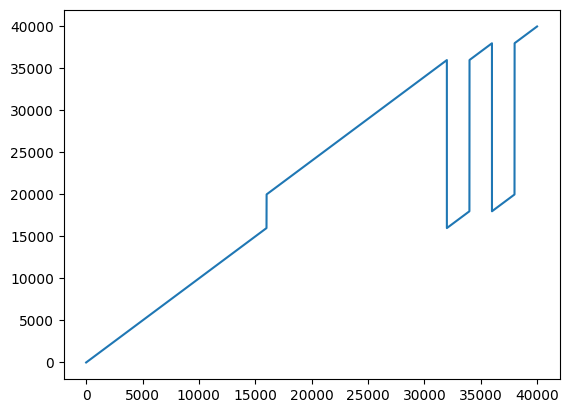

In [61]:
# plt.plot(torch.nonzero(d['Label'] == 0)[:,0].numpy())
# plt.plot(dm.f["Label"].numpy())
plt.plot(tr_idx + va_idx + te_idx)

In [71]:
assert list(set(range(total)) - set(tr_idx) - set(va_idx) - set(te_idx)) == []

In [33]:
torch.sort(d['Label'][:,0]).indices

tensor([26662, 26674, 26673,  ..., 24997, 24996, 24995])